Earlier versions of the sampler function. Evaluated in terms of run-time for better understanding and decision making. 

Also contains visualisations of the number of data segments in files and the distribution of lengths of these segments.

In [1]:
import pandas as pd
import numpy as np
import random
import os
import time
import matplotlib.pyplot as plt

In [2]:
def generate_random_samples(read, batch, sequence_length = 60):
    """
    A function that creates a list of independent arrays that are to serve as samples for processing later.
    read is the directory where Excel files containing variables are stored;
    batch is the number of samples that will be generated;
    sequence length is the length of each sample.
    Returns a list of numpy arrays.
    """

    def load_excel(file_path):
        """
        Extracts sheets from Excel files given a file directory.
        """
        excel_file = pd.ExcelFile(file_path)
        
        sheets = {sheet_name: pd.read_excel(excel_file, sheet_name = sheet_name) for sheet_name in excel_file.sheet_names}

        return sheets
    
    def random_file(read):
        """
        Chooses a random file from a provided directory.
        """
        files = [f for f in os.listdir(read) if f.endswith(".xlsx") and not f.startswith(".")]
        
        if not files:
            raise FileNotFoundError("No Excel files found in the directory")
        
        return os.path.join(read, random.choice(files))
    
    def sampler(sheet_data, sequence_length):
        """
        Randomly creates a sample from an Excel sheet.
        sheet_data are sheets representing time series segments from where data is going to be sampled
        sequence_length is the number of points each sample will contain.
        """

        num_points = len(sheet_data)

        if num_points < sequence_length:
            return None
        
        start_index = random.randint(0, num_points - sequence_length)
        end_index = start_index + sequence_length
        sample = sheet_data.iloc[start_index : end_index].to_numpy()

        return sample
    
    def weighted_random_choice(sheets):
        """
        Assigns weights to sheets based on the length of each sheet.
        """
        total_points = sum(len(data) for data in sheets.values())
        weights = [len(data) / total_points for data in sheets.values()]

        return random.choices(list(sheets.keys()), weights = weights, k = 1)[0]
    
    #Initializes list to strore sample arrays
    samples = []

    while len(samples) < batch:
        file_path = random_file(read)
        sheets = load_excel(file_path)

        while len(samples) < batch:
            sheet_name = weighted_random_choice(sheets)
            sheet_data = sheets[sheet_name][["velocity_x", "velocity_y", "velocity_y", "tortuosity3d", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]]
            sample = sampler(sheet_data, sequence_length)

            if sample is not None:
                samples.append(sample)

            #Stops once batch size is reached
            if len(samples) >= batch:
                break

    return samples

In [3]:
def generate_random_samples2(read, batch, sequence_length = 60):
    """
    A function that creates a list of independent arrays that are to serve as samples for processing later.
    read is the directory where Excel files containing variables are stored;
    batch is the number of samples that will be generated;
    sequence length is the length of each sample.
    Returns a list of numpy arrays.
    """

    def load_excel(file_path):
        """
        Extracts sheets from Excel files given a file directory.
        """
        excel_file = pd.ExcelFile(file_path)
        
        sheets = {sheet_name: pd.read_excel(excel_file, sheet_name = sheet_name) for sheet_name in excel_file.sheet_names}

        return sheets
    
    def random_file(read):
        """
        Chooses a random file from a provided directory.
        """
        files = [f for f in os.listdir(read) if f.endswith(".xlsx") and not f.startswith(".")]
        
        if not files:
            raise FileNotFoundError("No Excel files found in the directory")
        
        return os.path.join(read, random.choice(files))
    
    def sampler(sheet_data, sequence_length):
        """
        Randomly creates a sample from an Excel sheet.
        sheet_data are sheets representing time series segments from where data is going to be sampled
        sequence_length is the number of points each sample will contain.
        """

        num_points = len(sheet_data)

        if num_points < sequence_length:
            return None
        
        start_index = random.randint(0, num_points - sequence_length)
        end_index = start_index + sequence_length
        sample = sheet_data.iloc[start_index : end_index].to_numpy()

        return sample
    
    def weighted_random_choice(sheets):
        """
        Assigns weights to sheets based on the length of each sheet.
        """
        total_points = sum(len(data) for data in sheets.values())
        weights = [len(data) / total_points for data in sheets.values()]

        return random.choices(list(sheets.keys()), weights = weights, k = 1)[0]
    
    #Initializes list to strore sample arrays
    samples = []

    while len(samples) < batch:
        file_path = random_file(read)
        sheets = load_excel(file_path)

        #Picks a sheet based on length based weights
        sheet_name = weighted_random_choice(sheets)
        sheet_data = sheets[sheet_name][["velocity_x", "velocity_y", "velocity_y", "tortuosity3d", "angular_velocity_yz", "angular_velocity_xz", "angular_velocity_xy"]]

        #Creates a sample
        sample = sampler(sheet_data, sequence_length)

        if sample is not None:
            samples.append(sample)

    return samples

In [4]:
def timer(function, read, batch, sequence_length = 60, repeats = 10):
    """
    
    """

    times = []

    for _ in range(repeats):
        start_time = time.time()
        function(read, batch, sequence_length)
        end_time = time.time()
        run_time = end_time - start_time
        times.append(run_time)

    average = np.mean(times)
    std_dev = np.std(times)

    return average, std_dev

In [6]:
read = "/Users/maks/Documents/MSc_project/data/features"

In [12]:
average1, std_dev1 = timer(generate_random_samples, read, batch = 64)
#average2, std_dev2 = timer(generate_random_samples2, read, batch = 64)

print(f"When using two while loops - average time: {average1} seconds, standard deviation: {std_dev1} seconds")
#print(f"When using a single while loop - average time: {average2} seconds, standard deviation: {std_dev2} seconds")

When using two while loops - average time: 5.693648028373718 seconds, standard deviation: 2.6187303043802457 seconds


In [13]:
average2, std_dev2 = timer(generate_random_samples2, read, batch = 64, repeats = 1)
print(f"When using a single while loop - average time: {average2} seconds, standard deviation: {std_dev2} seconds")

When using a single while loop - average time: 325.68238377571106 seconds, standard deviation: 0.0 seconds


In [9]:
def visualise_no_of_segments(read):
    """
    A function to visualise the number of sheets within a directory containing Excel files. 
    For my purpose, this shows the number of time series data segments usable for sampling.
    read is the directory containing Excel files.
    """

    #Initializes a dictionary to store the number of sheets (or data segments)
    sheet_counts = {}

    #Iterates over all files in the directory
    for filename in os.listdir(read):
        if filename.endswith(".xlsx") and not filename.startswith("."):
            file_path = os.path.join(read, filename)

            #Loads in Excel file
            excel = pd.ExcelFile(file_path)

            #Counts the number of sheets
            sheet_counts[filename] = len(excel.sheet_names)

    #Creates a bar chart to visualise number of sheets per file
    plt.figure(figsize = (10, 6))
    bars = plt.bar(sheet_counts.keys(), sheet_counts.values())
    plt.xlabel("Excel files")
    plt.ylabel("Number of data segments")
    plt.title("Number of Available Data Segments per Excel File")
    plt.xticks(rotation = 45, ha = "right")
    plt.tight_layout()

    #Shows height of each bar
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f"{int(height)}", ha = "center", va = "bottom", fontsize = 6)
        
    plt.show()
    

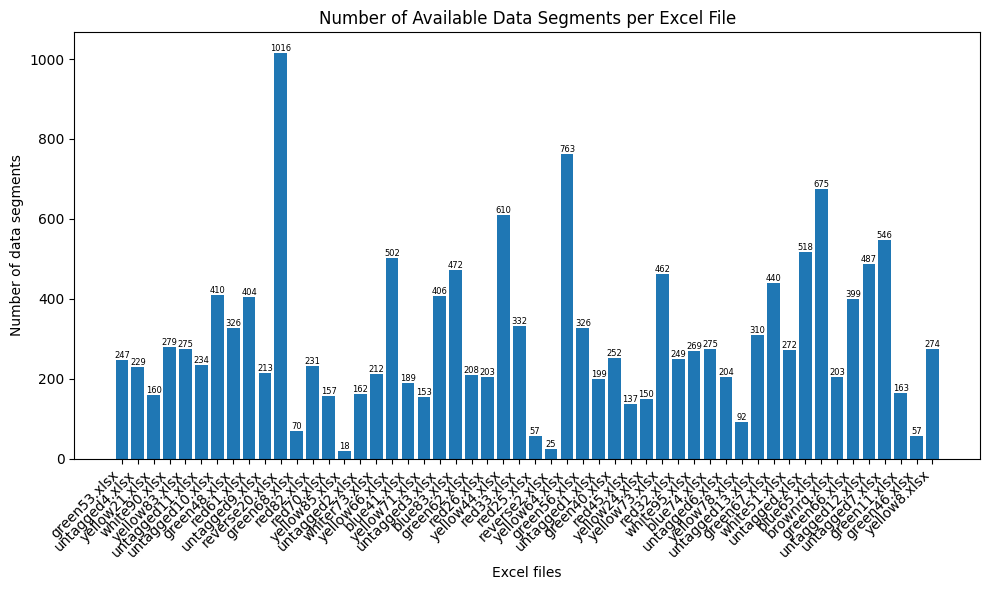

In [10]:
visualise_no_of_segments(read)

In [7]:
def segment_length_distribution(read):
    """
    A function to visualise the distribution of lengths of data sheets across all Excel fiels in a directory.
    read is the path to directory containing Excel files.
    """

    #Initialises list to store sheet lengths
    lengths = []
    #Iterates over all Excel fiels in a directory
    for filename in os.listdir(read):
        if filename.endswith(".xlsx") and not filename.startswith("."):
            file_path = os.path.join(read, filename)

            #Loads in Excel file
            excel = pd.ExcelFile(file_path)

            for sheet_name in excel.sheet_names:
                sheet_data = pd.read_excel(excel, sheet_name = sheet_name)
                lengths.append(len(sheet_data) / 30)

    plt.figure(figsize = (10,6))
    counts, bins, patches = plt.hist(lengths, bins = 30)
    plt.xlabel("Lengths of segments [seconds]")
    plt.ylabel("Frequency")
    plt.yscale("log")
    plt.title("Distribution of Segment Lengths Across Available Excel Files")
    plt.grid(True)

    #Shows the frequency on each bar
    for count, patch in zip(counts, patches):
        height = patch.get_height()
        if height > 0:
            plt.text(patch.get_x() + patch.get_width() / 2, height, f"{int(count)}", ha = "center", va = "bottom", fontsize = 9)
    plt.show()    

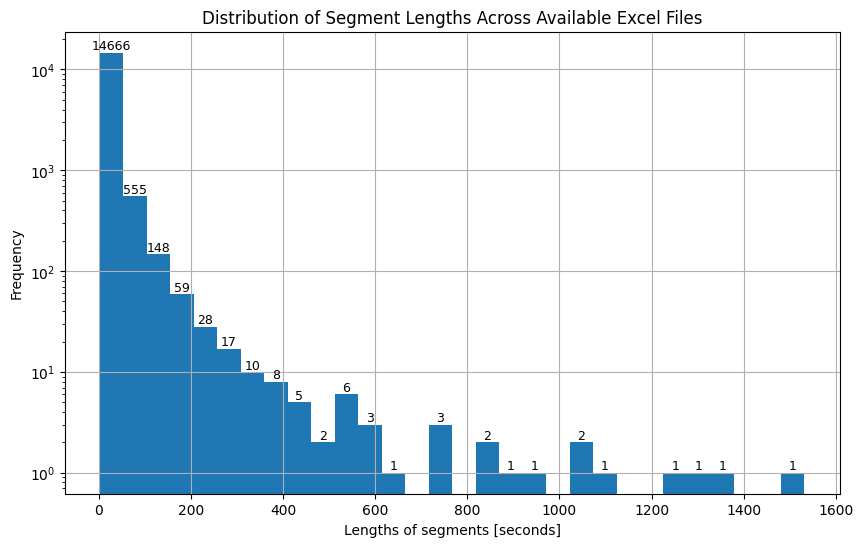

In [8]:
segment_length_distribution(read)

In [33]:
average3, std_dev3 = timer(generate_random_samples, read, batch = 64, repeats = 100)

print(f"When using two while loops - average time: {average3} seconds, standard deviation: {std_dev3} seconds")

When using two while loops - average time: 4.70582661151886 seconds, standard deviation: 3.2099168582841275 seconds


In [34]:
average4, std_dev4 = timer(generate_random_samples2, read, batch = 64, repeats = 10)

print(f"When using a single while loop - average time: {average4} seconds, standard deviation: {std_dev4} seconds")

When using a single while loop - average time: 286.2178255081177 seconds, standard deviation: 19.277915908252094 seconds


In [44]:
average5, std_dev5 = timer(generate_random_samples, read, batch = 480, repeats = 1)

print(f"When using two while loops - average time: {average5} seconds, standard deviation: {std_dev5} seconds")

When using two while loops - average time: 3.215111017227173 seconds, standard deviation: 0.0 seconds
